In [ ]:
import tensorflow as tf
from tensorflow.python.keras.layers import Conv2D
import matplotlib.pyplot as plt

## Learning Objective Error Map

In the first stage of training, the objective error maps are used as proxy regression targets to get the effect of 
increasing data. The loss function is defined by the mean squared error between the predicted and ground-truth error
maps.

\begin{align*}
\mathcal{L}_1(\hat{I}_d; \theta_f, \theta_g) = ||g(f(\hat{I}_d, \theta_f), \theta_g) - \mathbf{e}_{gt}) \odot \mathbf{\hat{r}}||^2_2
\end{align*}

where,

\begin{align*}
\mathbf{e}_{gt} = err(\hat{I}_r, \hat{I}_d)
\end{align*}

and $err(\cdot)$ is any error function. The authors decided to use

\begin{align*}
\mathbf{e}_{gt} = | \hat{I}_r -  \hat{I}_d | ^ p
\end{align*}

with $p=0.2$ in order to prevent that the values in the error map are small or close to zero.

In [ ]:
@tf.function
def error_map(reference: tf.Tensor, distorted: tf.Tensor, p: float=0.2) -> tf.Tensor:
    assert reference.shape == distorted.shape, 'Both images must be of the same size'
    return tf.pow(tf.abs(reference - distorted), p)

## Reliability Map Prediction

According to the author, the model is likely to fail to predict the objective error map of
homogeneous regions without having information of its pristine image. Thus, he proposes a 
reliability function. The assumption is that blurry regions have lower reliability than textured 
regions.

\begin{align*}
\mathbf{r} = \frac{2}{1 + exp(-\alpha|\hat{I}_d|)} - 1
\end{align*}

where α controls the saturation property of the reliability map. To assign sufficiently
large values to pixels with small values, the positive part of a sigmoid is used.

In [ ]:
@tf.function
def reliability_map(distorted: tf.Tensor, alpha: float) -> tf.Tensor:
    assert distorted.dtype == tf.float32, 'The Tensor must by of dtype tf.float32'
    return 2 / (1 + tf.exp(- alpha * tf.abs(distorted)))

Besides, to prevent the reliability map to directly affect the predicted score,
it is divided by its average

\begin{align*}
\mathbf{\hat{r}} = \frac{1}{\frac{1}{H_rW_r}\sum_{(i,j)}\mathbf{r}(i,j)}\mathbf{r}
\end{align*}

In [ ]:
@tf.function
def average_reliability_map(distorted: tf.Tensor, alpha: float) -> tf.Tensor:
    r = reliability_map(distorted, alpha)
    return 1 / tf.reduce_mean(r) * r

In [25]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32').reshape(60000, 28, 28, 1) / 255
x_test = x_test.astype('float32').reshape(10000, 28, 28, 1) / 255
y_train = tf.image.resize(x_train, [7, 7])

In [108]:
input = tf.keras.Input(shape=(None, None, 1), batch_size=1, name='original_image')
f = Conv2D(48, (3, 3), name='Conv1', activation='relu', padding='same')(input)
f = Conv2D(48, (3, 3), name='Conv2', activation='relu', padding='same', strides=(2, 2))(f)
f = Conv2D(64, (3, 3), name='Conv3', activation='relu', padding='same')(f)
f = Conv2D(64, (3, 3), name='Conv4', activation='relu', padding='same', strides=(2, 2))(f)
f = Conv2D(64, (3, 3), name='Conv5', activation='relu', padding='same')(f)
f = Conv2D(64, (3, 3), name='Conv6', activation='relu', padding='same')(f)
f = Conv2D(128, (3, 3), name='Conv7', activation='relu', padding='same')(f)
f = Conv2D(128, (3, 3), name='Conv8', activation='relu', padding='same')(f)
g = Conv2D(1, (1, 1), name='Conv9', padding='same', activation='linear')(f)
objective_error_map = tf.keras.Model(input, g, name='objective_error_map')

In [ ]:
optimizer = tf.optimizers.Nadam(learning_rate=2 * 10 ** -4)
objective_error_map.compile(
    optimizer=optimizer,
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanSquaredError()])

In [ ]:
objective_error_map.summary()

Model: "objective_error_map"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_image (InputLayer)  [(1, None, None, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (1, None, None, 48)       480       
_________________________________________________________________
Conv2 (Conv2D)               (1, None, None, 48)       20784     
_________________________________________________________________
Conv3 (Conv2D)               (1, None, None, 64)       27712     
_________________________________________________________________
Conv4 (Conv2D)               (1, None, None, 64)       36928     
_________________________________________________________________
Conv5 (Conv2D)               (1, None, None, 64)       36928     
_________________________________________________________________
Conv6 (Conv2D)               (1, None, None, 64

In [19]:
history = objective_error_map.fit(x_train, y_train,
                    batch_size=1,
                    epochs=1,
                    validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
48000/48000 [==============================] - 429s 9ms/sample - loss: 6.9691e-05 - mean_squared_error: 6.9691e-05 - val_loss: 1.1924e-05 - val_mean_squared_error: 1.1924e-05


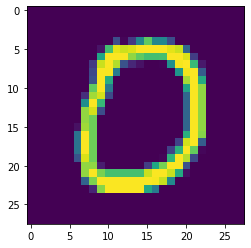

In [44]:
plt.imshow(x_test[10:11].reshape([28, 28]))
plt.show()

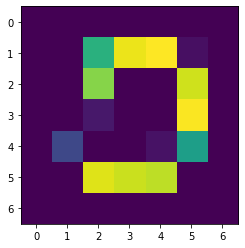

In [45]:
x = objective_error_map.predict(x_test[10:11])
plt.imshow(x.reshape([7, 7]))
plt.show()